## Rod Control Example

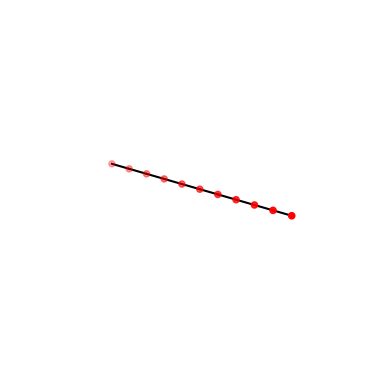

In [1]:
import numpy as np
import time
import dismech

geom = dismech.GeomParams(
    rod_r0=2e-2,
    shell_h=0.0,
)

material = dismech.Material(density=2000,
                            youngs_rod=1e3,
                            youngs_shell=0,
                            poisson_rod=0.5,
                            poisson_shell=0)

dynamic_2d_sim = dismech.SimParams(static_sim=True,
                                  two_d_sim=True,   # no twisting
                                  use_mid_edge=False,
                                  use_line_search=False,
                                  show_floor=False,
                                  log_data=True,
                                  log_step=1,
                                  dt=1e-3,
                                  max_iter=25,
                                  total_time=1,
                                  plot_step=1,
                                  tol=1e-4,
                                  ftol=1e-4,
                                  dtol=1e-2)

env = dismech.Environment()
env.add_force('gravity', g=np.array([0.0, 0.0, 0]))
env.add_force('damping', eta=10)
env.set_static()

geo = dismech.Geometry.from_txt(
    '../tests/resources/rod_cantilever/horizontal_rod_n11.txt')

robot = dismech.SoftRobot(geom, material, geo, dynamic_2d_sim, env)

In [2]:
fixed_points = np.array([0, 10]) # Fix the first and last node

robot = robot.fix_nodes(fixed_points)
stepper = dismech.ImplicitEulerTimeStepper(robot)

## Reference configuration from csv

In [3]:
import json
import numpy as np
from types import SimpleNamespace

def dict_to_state_namespace(d):
    # convert lists -> np.array where appropriate
    cooked = {}
    for k, v in d.items():
        cooked[k] = np.array(v) if isinstance(v, list) else v
    return SimpleNamespace(**cooked)

with open("final_state.json", "r") as f:
    ref_state_dict = json.load(f)

ref_state = dict_to_state_namespace(ref_state_dict)

be = stepper.elastic_energies['bend']
kappa_ref = be.get_strain(ref_state)
print("Reference bending strain:", kappa_ref)


Reference bending strain: [[ 0.10012266 -0.        ]
 [ 0.19104108 -0.        ]
 [ 0.29728818 -0.        ]
 [ 0.39098603 -0.        ]
 [ 0.42854861 -0.        ]
 [ 0.39098603 -0.        ]
 [ 0.29728818 -0.        ]
 [ 0.19104108 -0.        ]
 [ 0.10012266 -0.        ]]


### Time Stepping
PID Control

In [4]:
# from dismech.controllers.longitudinalPI import LongitudinalPI
from dismech.controllers.curvaturePI import CurvaturePI

Kp = 1
Ki = 50
Kd = 0.0

nat0 = robot.bend_springs.nat_strain.copy()  
curv_pid = CurvaturePI(kappa_ref, nat0,
                       Kp=Kp, Ki=Ki, Kd=Kd,     # keep Kd=0 unless you use velocity-based damping
                       du_rate=0.10,                # per-step max |Δ nat curvature|
                       smooth_alpha=0.20,
                       kappa_max=np.inf)            # or set a physical cap

dt = dynamic_2d_sim.dt
bend_energy = None
pos_errors = []
strain_errors = []

def before_step_fn(rb, t):
    
    # update gravity slowly
    robot.env.g = robot.env.static_g * t / robot.sim_params.total_time

    # fetch BendEnergy from the stepper on every call (cheap)
    se = stepper.elastic_energies['bend']

    # 1) measure current edge strains from the current state
    kappa_meas = se.get_strain(rb.state)  # (N_edges,)

    # 2) PI update on natural strain (in-place write)
    curv_pid.update(kappa_meas, rb.bend_springs.nat_strain, dt)

    # print the error between target and measured strain
    err = np.linalg.norm(kappa_meas - kappa_ref) / np.sqrt(len(kappa_meas))
    strain_errors.append(err)
    # print(f"t={t:.3f}, ||eps-eps_ref||={err:.6f}")

    # also print the error between the state and the reference (nodal positions)
    curr_pos = rb.state.q[0:rb.end_node_dof_index] # (N_nodes*3,)
    ref_pos = ref_state.q[0:rb.end_node_dof_index] # (N_nodes*3,)
    pos_err = np.linalg.norm(curr_pos - ref_pos) / np.sqrt(len(curr_pos))
    # print(f"t={t:.3f}, ||pos-ref_pos||={pos_err:.6f}")

    # save this pos_err for later plotting
    pos_errors.append(pos_err)

    return rb


In [5]:

stepper.before_step = before_step_fn
robots = stepper.simulate()
qs = np.stack([robot.state.q for robot in robots])


iter: 1, error: 0.178
iter: 2, error: 0.002
current_time:  0.001
iter: 1, error: 0.172
iter: 2, error: 0.003
current_time:  0.002
iter: 1, error: 0.154
iter: 2, error: 0.002
current_time:  0.003
iter: 1, error: 0.191
iter: 2, error: 0.003
current_time:  0.004
iter: 1, error: 0.207
iter: 2, error: 0.004
current_time:  0.005
iter: 1, error: 0.202
iter: 2, error: 0.002
current_time:  0.006
iter: 1, error: 0.233
iter: 2, error: 0.003
current_time:  0.007
iter: 1, error: 0.256
iter: 2, error: 0.004
current_time:  0.008
iter: 1, error: 0.273
iter: 2, error: 0.004
current_time:  0.009000000000000001
iter: 1, error: 0.286
iter: 2, error: 0.005
iter: 3, error: 0.000
current_time:  0.01
iter: 1, error: 0.296
iter: 2, error: 0.005
iter: 3, error: 0.000
current_time:  0.011
iter: 1, error: 0.302
iter: 2, error: 0.005
iter: 3, error: 0.000
current_time:  0.012
iter: 1, error: 0.284
iter: 2, error: 0.003
iter: 3, error: 0.000
current_time:  0.013000000000000001
iter: 1, error: 0.281
iter: 2, error: 

In [6]:
t = np.arange(robot.sim_params.total_time, step=robot.sim_params.dt)
options = dismech.AnimationOptions(title='Rod PID', plot_step=1)

fig = dismech.get_interactive_animation_plotly(robot, t, qs, options)
fig.show()

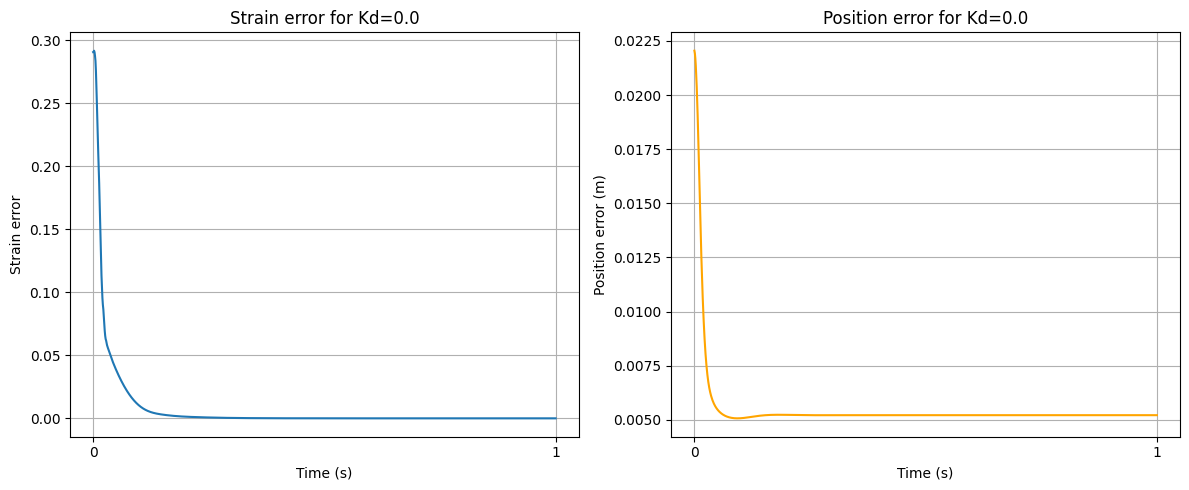

In [7]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
# make the strain error and position error plots side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))   
ax1.plot(t, strain_errors)
ax1.set_title("Strain error for Kd={Kd}".format(Kd=Kd))
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Strain error")
ax1.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax1.grid(True)
ax2.plot(t, pos_errors, color='orange')
ax2.set_title("Position error for Kd={Kd}".format(Kd=Kd))
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Position error (m)")
ax2.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax2.grid(True)
plt.tight_layout()
plt.show()

/tmp/ipykernel_10082/826862052.py:11: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



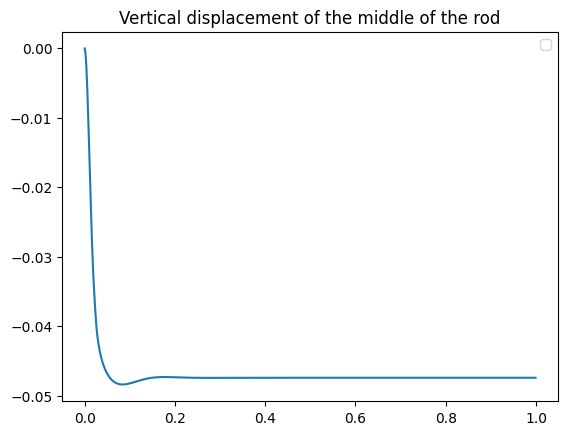

In [8]:
import matplotlib.pyplot as plt

middle_dof_ind = robot.map_node_to_dof(5)  
ax = plt.gca()
ax.ticklabel_format(style='plain', axis='y')

t = np.arange(0, robot.sim_params.total_time, robot.sim_params.dt)
plt.plot(t, qs[:, middle_dof_ind[2]]) # plot the middle node's z-coordinate

plt.title("Vertical displacement of the middle of the rod")
plt.legend()
plt.show()

In [9]:
# import json
# import numpy as np

# def save_robot_state_to_json(state, filename="final_state.json"):
#     """
#     Save the entire RobotState object to a JSON file.
#     Automatically converts numpy arrays to lists.
#     """
#     state_dict = {}
    
#     # loop through all attributes of the state
#     for attr in dir(state):
#         # skip private attributes and methods
#         if attr.startswith("_"):
#             continue
#         val = getattr(state, attr)
        
#         # skip callables (methods, properties that are functions)
#         if callable(val):
#             continue
        
#         # convert numpy arrays to lists for JSON serialization
#         if isinstance(val, np.ndarray):
#             state_dict[attr] = val.tolist()
#         else:
#             # handle nested numpy arrays or None/float/int
#             try:
#                 json.dumps(val)  # test if JSON serializable
#                 state_dict[attr] = val
#             except TypeError:
#                 # fallback for unknown types (e.g., other custom objects)
#                 state_dict[attr] = str(val)

#     # write to JSON
#     with open(filename, "w") as f:
#         json.dump(state_dict, f, indent=2)

# # --- usage ---
# final_state = robots[-1].state
# save_robot_state_to_json(final_state, "final_state.json")
# print("Saved full state to final_state.json")
